In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import mpl_finance as mpf 
from talib import abstract
from keras.backend import clear_session
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, SimpleRNN, LSTM, GRU

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [51]:
def read_data(fileName='S_P.csv', dateColumn='Date', startDate='2019-01-01', endDate='2019-12-31'):
    df = pd.read_csv(fileName)
    df[dateColumn] = pd.to_datetime(df[dateColumn])
    mask = (df[dateColumn] >= startDate) & (df[dateColumn] <= endDate)
    df_loc = df.loc[mask]
    df_loc.reset_index(drop=True, inplace=True)
    df_loc.set_index("Date", inplace=True)
    df_loc.index = df_loc.index.format(formatter=lambda x: x.strftime('%Y-%m-%d')) 
    
    return df_loc

def moving_average(df, timeperiod):
    sma = abstract.SMA(df['Close'], timeperiod = timeperiod)
    sma_df = pd.Series(sma)
    sma_df.index = df['Close'].index
   
    column_name = 'MA_' + str(timeperiod)
    if column_name in df:
        pass
    else:
        df[column_name] = sma_df
        # df = df.fillna(0)       ######### 要不要補零? 還是NaN也可以?
    
    return df
    
def kd(df):
    KD = abstract.STOCH(df, prices=['High', 'Low', 'Close'])
    KD.index = df['Close'].index
    if 'K' not in df:
        df['K'] = KD['slowk']
    if 'D' not in df:
        df['D'] = KD['slowd']
        
    df = df.fillna(0)
    return df

def plot_candlestick_kdline_volumebar(draw_df):
    # create figure
    fig = plt.figure(figsize=(24, 15))

    # add_axes (initial_x, initial_y, weight, height)
    ax_candlestick = fig.add_axes([0, 0.5, 1, 0.5])
    ax_kdline = fig.add_axes([0, 0.3, 1, 0.2])
    ax_volumebar = fig.add_axes([0, 0, 1, 0.3])

    ##### candlestick #####
    # matplotlib.finance.candlestick2_ochl(ax, opens, closes, highs, lows, width=4, colorup='k', colordown='r', alpha=0.75)
    mpf.candlestick2_ochl(ax_candlestick, draw_df['Open'], draw_df['Close'], draw_df['High'], draw_df['Low'], width=0.75, colorup='r', colordown='g', alpha=0.75);

    ##### moving average #####
    # talic.abstract.SMA([input_arrays], [timeperiod=30])
    sma_10 = abstract.SMA(draw_df['Close'], timeperiod = 10)
    sma_30 = abstract.SMA(draw_df['Close'], timeperiod = 30)
    ax_candlestick.plot(sma_10, label='MA 10')
    ax_candlestick.plot(sma_30, label='MA 30')

    ##### KD line ####
    kd(draw_df)
    ax_kdline.plot(draw_df['K'], label='K')
    ax_kdline.plot(draw_df['D'], label='D')

    ##### volume #####
    # matplotlib.finance.volume_overlay(ax, opens, closes, volumes, colorup='k', colordown='r', width=4, alpha=1.0)
    mpf.volume_overlay(ax_volumebar, draw_df['Open'], draw_df['Close'], draw_df['Volume'], colorup='r', colordown='g', width=0.5, alpha=0.75)

    # x axis
    ax_volumebar.set_xticks(range(0, len(draw_df.index), 10))
    ax_volumebar.set_xticklabels(draw_df.index[::10]) #, rotation=90

    # legend
    ax_candlestick.legend(loc='upper right')
    ax_kdline.legend(loc='upper right')

    plt.show()
    
def normalize(df):
    
    normalized_df = (df-df.min())/(df.max()-df.min())
    
    return normalized_df 

def transform_dimension(X, Y, Time_steps=30, out_days=1):
    train_data = []
    label = []

    Input_dim = len(X.columns)

    # create dataset
    training = X.values
    #for i in range(Time_steps, len(training)-out_days, out_days):
        #training_batch = training[i-Time_steps:i+out_days, :]
    
    for i in range(Time_steps, len(training)-out_days):
        training_batch = training[i-Time_steps:i+out_days, :]
        train_data.append(training_batch[:Time_steps, :])
        label.append(training_batch[Time_steps:Time_steps+out_days, 3]) # index:3 --> close

    # change to np array
    train_data, label = np.asarray(train_data), np.asarray(label)
    print('trainX shape: ',train_data.shape, '\ntrainY shape: ',label.shape)
    print('batch size, time step: ', train_data.shape[1],', input dimension: ', train_data.shape[2])
    
    return train_data, label

def history2plot(historydf):
    # Learning curve: summarize history for loss 
    plt.plot(historydf['loss']) 
    plt.plot(historydf['val_loss']) 
    plt.title('Learning Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left') 
    plt.show()
    
def prediction2plot(predicted_stock_price, testX, testY_, timestep=30):
    # the prediction of ’Close’ value
    plt.figure(figsize=(20,10))
    plt.plot(testY_, 'b-', label = 'real')  
    plt.plot(predicted_stock_price, 'r--', label = 'predicted') 
    plt.legend(loc='upper right')
    testX_i = testX.index[timestep:-1]
    plt.xticks(ticks=range(0, len(testX.index), 40), labels=testX_i[::40])
    #plt.xticks(ticks=range(0, len(testX.index), 40), labels=testX.index[::40])
    plt.show()

def train_SimpleRNN(trainX, trainY, testX, testY, model_name, input_length, input_dim, batch_size=10, epochs=15):

    # Define a model
    model = Sequential([
        SimpleRNN(units=24, return_sequences=False, input_shape=(input_length, input_dim)),
        Dropout(0.2),
        Dense(1, activation='sigmoid'),
    ])

    # summary
    model.summary()
    
    # compile
    model.compile(optimizer='adam' , loss = 'mse', metrics = ['accuracy'])
    
    # train
    history = model.fit(trainX, trainY, batch_size = batch_size, epochs = epochs, validation_data = (testX, testY))
    
    model.save("model//" + model_name) 

    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to csv: 
    hist_csv_file = "model//" + model_name + "_history.csv"
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def train_LSTM(trainX, trainY, testX, testY, model_name, input_length, input_dim, batch_size=10, epochs=15):
    clear_session()
    
    # Define a model
    model = Sequential([
        LSTM(units=24,  return_sequences=False ,input_shape=(input_length, input_dim)),
        Dropout(0.2),
        Dense(1, activation='sigmoid'),
    ])

    # summary
    model.summary()
    
    # compile
    model.compile(optimizer='adam' , loss = 'mse', metrics = ['accuracy'])
    
    # train
    history = model.fit(trainX, trainY, batch_size = batch_size, epochs = epochs, validation_data = (testX, testY))

    # save model
    model.save("model//" + model_name) 

    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to csv: 
    hist_csv_file = "model//" + model_name + "_history.csv"
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def train_GRU(trainX, trainY, testX, testY, model_name, input_length, input_dim, batch_size=10, epochs=15):
    clear_session()
    
    # Define a model
    model = Sequential([
        GRU(units=24,  return_sequences=False ,input_shape=(input_length, input_dim)),
        Dropout(0.2),
        Dense(1, activation='sigmoid'),
    ])

    # summary
    model.summary()
    
    # compile
    model.compile(optimizer='adam' , loss = 'mse', metrics = ['accuracy'])
    
    # train
    history = model.fit(trainX, trainY, batch_size = batch_size, epochs = epochs, validation_data = (testX, testY))
    
    # save model
    model.save("model//" + model_name) 

    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to csv: 
    hist_csv_file = "model//" + model_name + "_history.csv"
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

In [4]:
draw_df = read_data('S_P.csv', 'Date', '2019-01-01', '2019-12-31')
train_df = read_data('S_P.csv', 'Date', '1994-01-01', '2017-12-31')
validation_df = read_data('S_P.csv', 'Date', '2018-01-01', '2019-12-31')

(i) (20%) Please use S P.csv to plot
* Candlestick chart with 2 moving average line (10 days and 30 days).
* KD line chart.
* Volume bar chart.

Show your figures from 2019/1/1 to 2019/12/31.

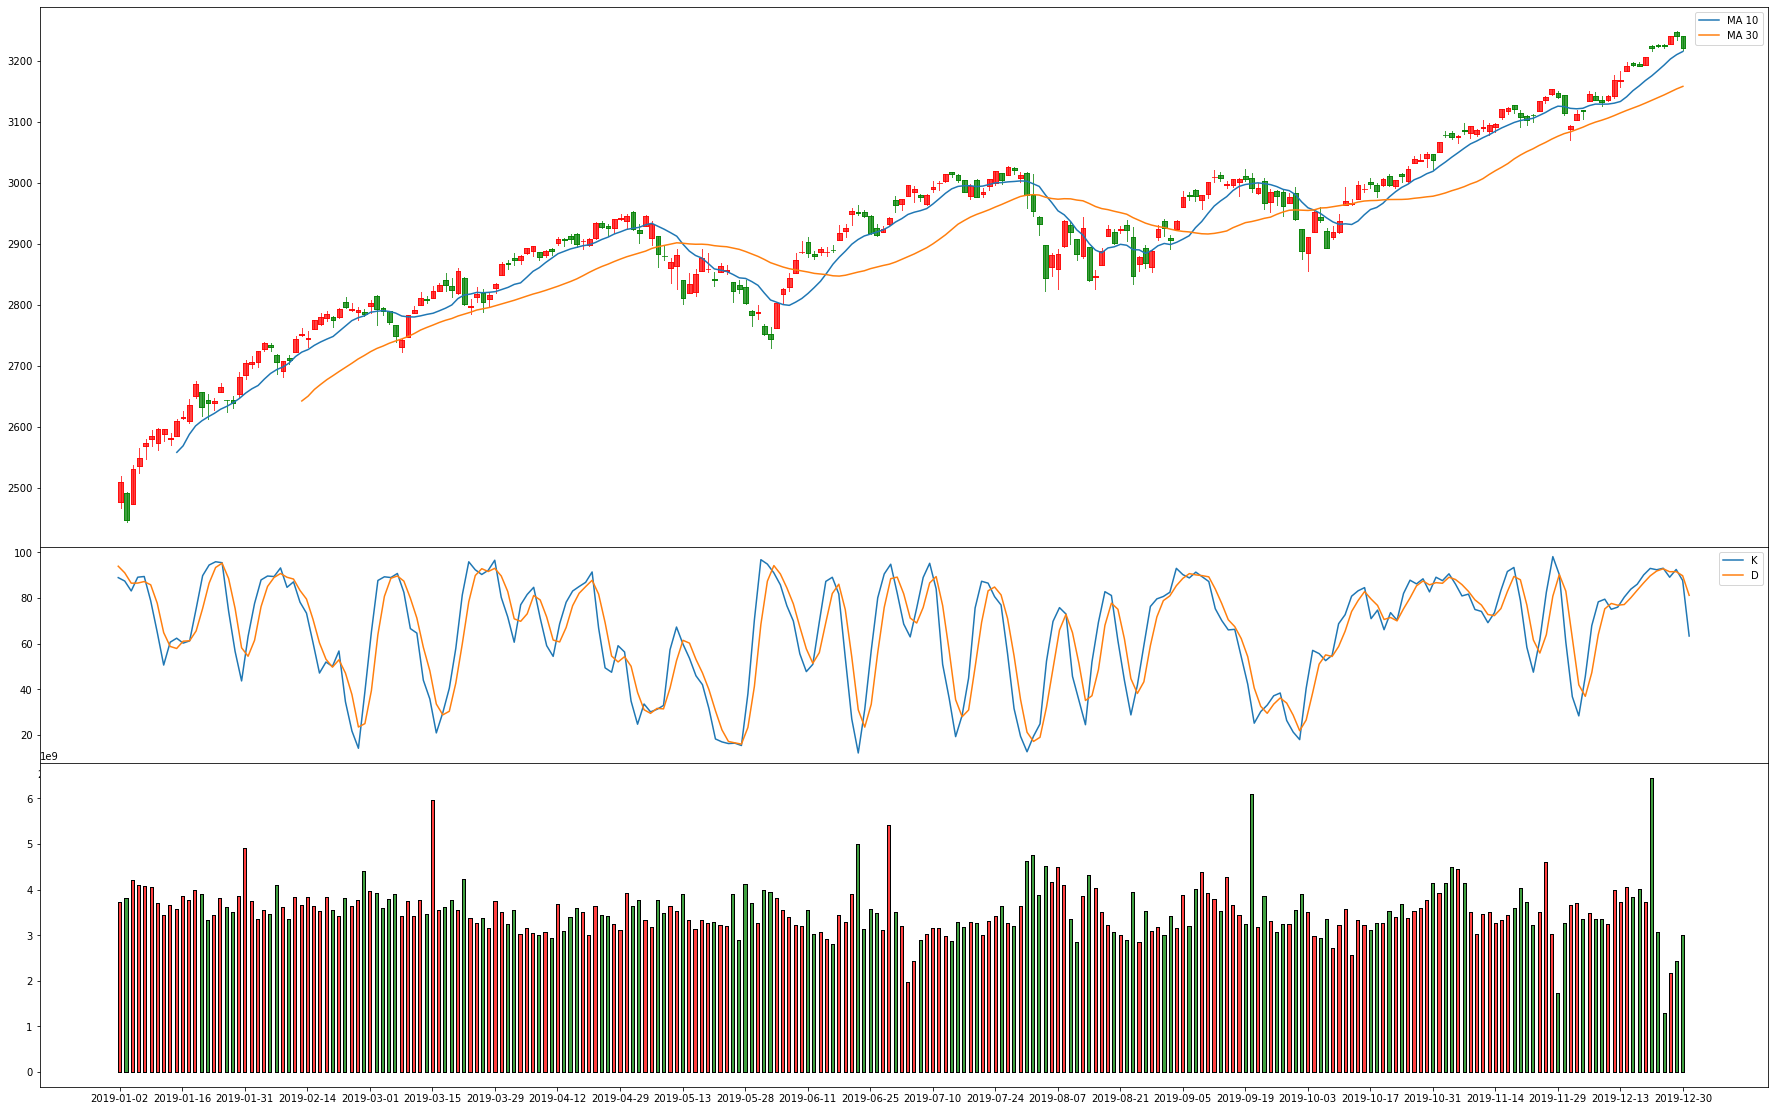

In [5]:
plot_candlestick_kdline_volumebar(draw_df)

(ii) (15%) Please at least add 4 features from question (i) into your input which are 
* ’Moving Average 10 days’, 
* ’Moving Average 30 days’ and 
* ’K,D from KD line chart’. 

And we want all features except Date to be normalized on a scale of 0 to 1 by the below equation. You can also add other features to help your model get better performance (e.g. If you think weekdays are important to stock price, you can add an one-hot attribute of weekday. Please discuss what did you do for data preprocessing.

In [5]:
# trainind data

##### adding features #####
moving_average(train_df, 10)
moving_average(train_df, 30)
kd(train_df)
# day? 

##### X, Y #####
trainY = train_df['Close']
trainX = train_df.drop(columns=['Close', 'Adj Close'])

##### normalization #####
trainX = normalize(trainX)

##### drop the record that has NaN value #####
trainX.dropna(inplace=True)

# validation data

##### adding features #####
moving_average(validation_df, 10)
moving_average(validation_df, 30)
kd(validation_df)
# day? 

##### X, Y #####
testY = validation_df['Close']
testX = validation_df.drop(columns=['Close', 'Adj Close'])

##### normalization #####
testX = normalize(testX)

##### drop the record that has NaN value #####
testX.dropna(inplace=True)

(iii) (10%) In RNN model, data dimension can be confused. Like the figure 2, RNN has 3 dimension
which can be written as (batch size, time step, input dimension). In this exercise, You can
choose the batch size on your design. The time step should be 30 because we want to use the
last 30 days to predict the ’Close’ value of the next day. And input dimension will be depend
on your (ii) design.

In [33]:
Batch_size = 10
Time_steps = 30
Input_dim = len(trainX.columns)
print(Input_dim)

8


In [40]:
print(len(trainX))

6014


In [7]:
trainX_, trainY_ = transform_dimension(trainX, trainY, Time_steps=30, out_days=1)

trainX shape:  (5983, 30, 8) 
trainY shape:  (5983, 1)
batch size, time step:  30 , input dimension:  8


In [8]:
testX_, testY_ = transform_dimension(testX, testY, Time_steps=30, out_days=1)

trainX shape:  (442, 30, 8) 
trainY shape:  (442, 1)
batch size, time step:  30 , input dimension:  8


(iv) (10%) Please construct a RNN model with SimpleRNN cell for predicting the ’Close’ value of the next day according to mean square error

(v) (10%) Plot loss curve chart and the prediction of ’Close’ value in validation part.

In [216]:
# train_SimpleRNN(trainX_, trainY_, testX_, testY_, 'SimpleRNN_', Time_steps, Input_dim)

In [14]:
simpleRNN_model = load_model('model\SimpleRNN_batch10')
simpleRNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 24)                792       
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 817
Trainable params: 817
Non-trainable params: 0
_________________________________________________________________


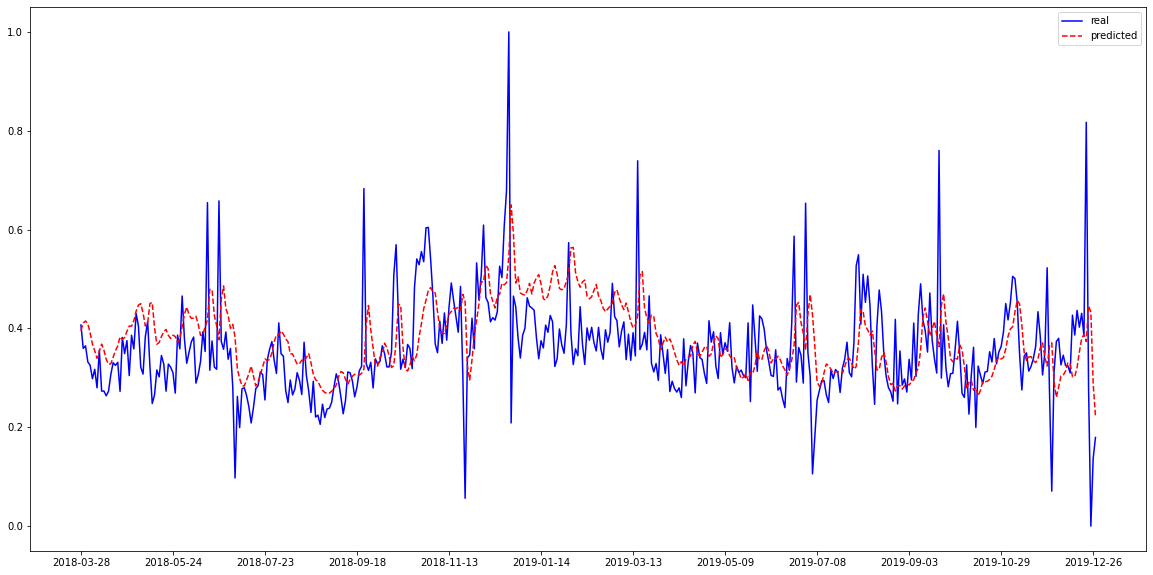

In [52]:
predicted_stock_price_simpleRNN = simpleRNN_model.predict(testX_)
prediction2plot(predicted_stock_price_simpleRNN, testX, testY_)

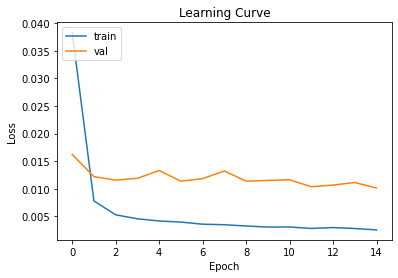

In [16]:
hist_df_read_simpleRNN = pd.read_csv('model\SimpleRNN_batch10_history.csv',index_col=0)
history2plot(hist_df_read_simpleRNN)

(vi) (10%) Substitute LSTM cell for SimpleRNN and repeat (iv), (v).

In [247]:
# train_LSTM(trainX_, trainY_, testX_, testY_, 'LSTM_', Time_steps, Input_dim)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24)                3168      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 3,193
Trainable params: 3,193
Non-trainable params: 0
_________________________________________________________________
Train on 5983 samples, validate on 442 samples
Epoch 1/15
5983/5983 [==============================] - 7s 1ms/step - loss: 0.0113 - accuracy: 3.3428e-04 - val_loss: 0.0109 - val_accuracy: 0.0023
Epoch 2/15
5983/5983 [==============================] - 7s 1ms/step - loss: 0.0031 - accuracy: 1.6714e-04 - val_loss: 0.0093 - val_accuracy: 0.0045
Epoch 3/15
5983/5983 [=================

In [18]:
LSTM_model = load_model('model\LSTM_batch10')
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24)                3168      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 3,193
Trainable params: 3,193
Non-trainable params: 0
_________________________________________________________________


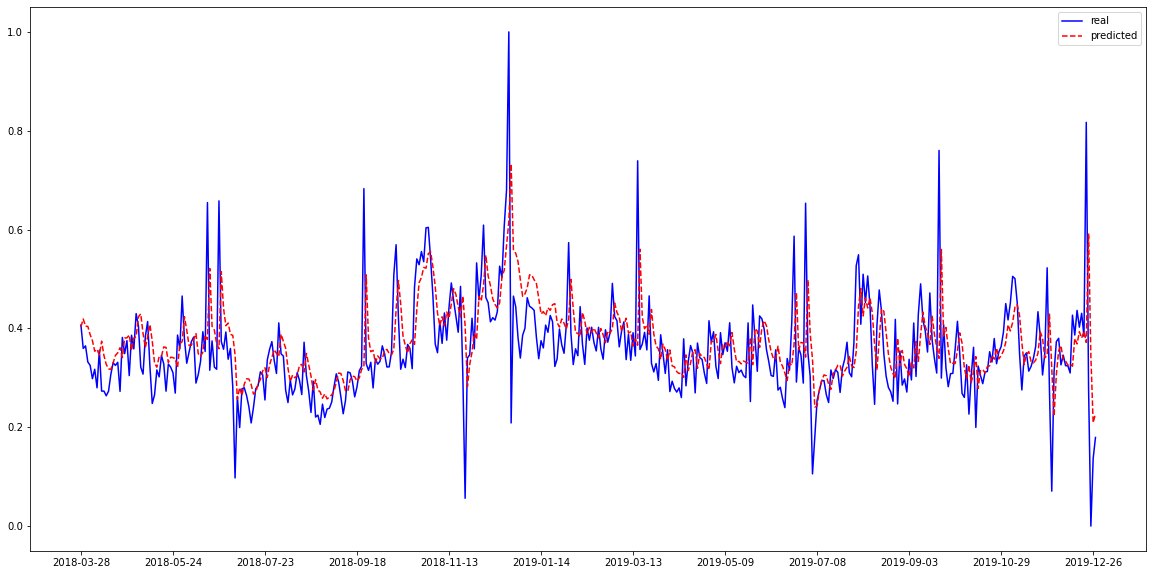

In [53]:
predicted_stock_price_LSTM = LSTM_model.predict(testX_)
prediction2plot(predicted_stock_price_LSTM, testX, testY_)

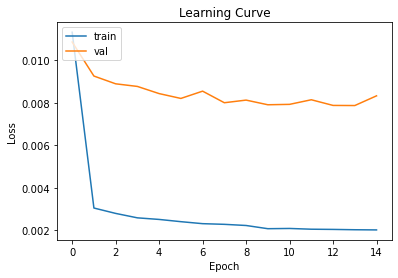

In [20]:
hist_df_read = pd.read_csv('model\LSTM_batch10_history.csv',index_col=0)
history2plot(hist_df_read)

(vii) (10%) Substitute GRU cell for SimpleRNN and repeat (iv), (v).

In [267]:
# train_GRU(trainX_, trainY_, testX_, testY_, 'GRU_batch10_', Time_steps, Input_dim)

In [22]:
GRU_model = load_model('model\GRU_batch10')
GRU_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 24)                2376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


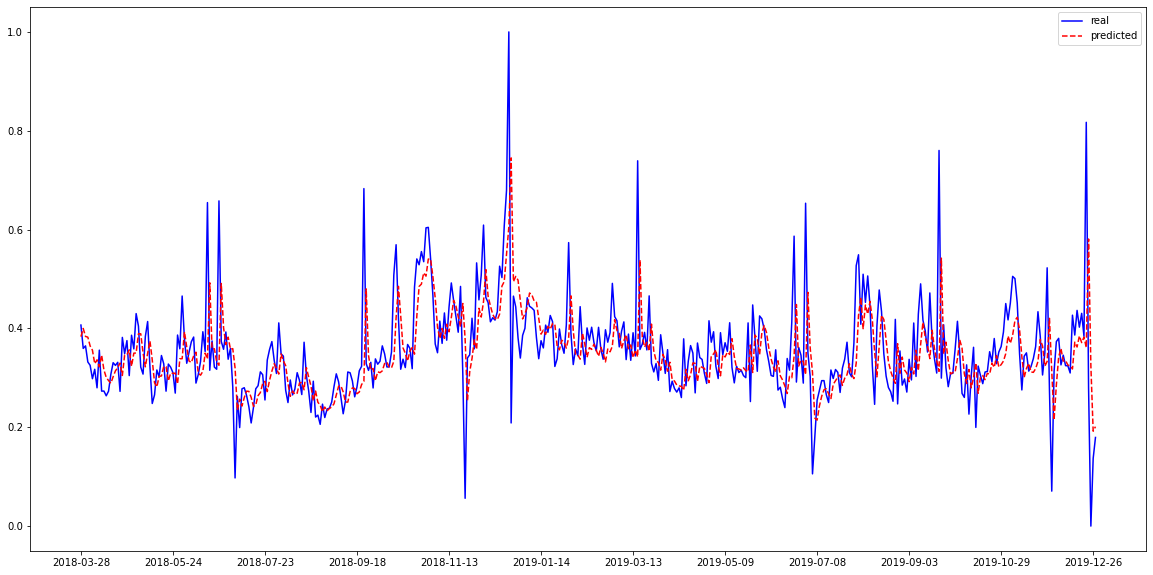

In [54]:
predicted_stock_price_GRU = GRU_model.predict(testX_)
prediction2plot(predicted_stock_price_GRU, testX, testY_)

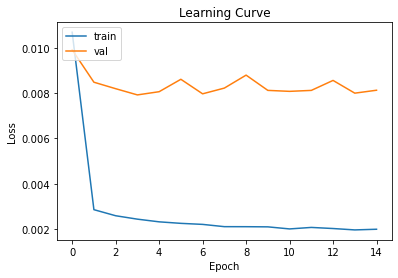

In [24]:
hist_df_read = pd.read_csv('model\GRU_batch10_history.csv',index_col=0)
history2plot(hist_df_read)

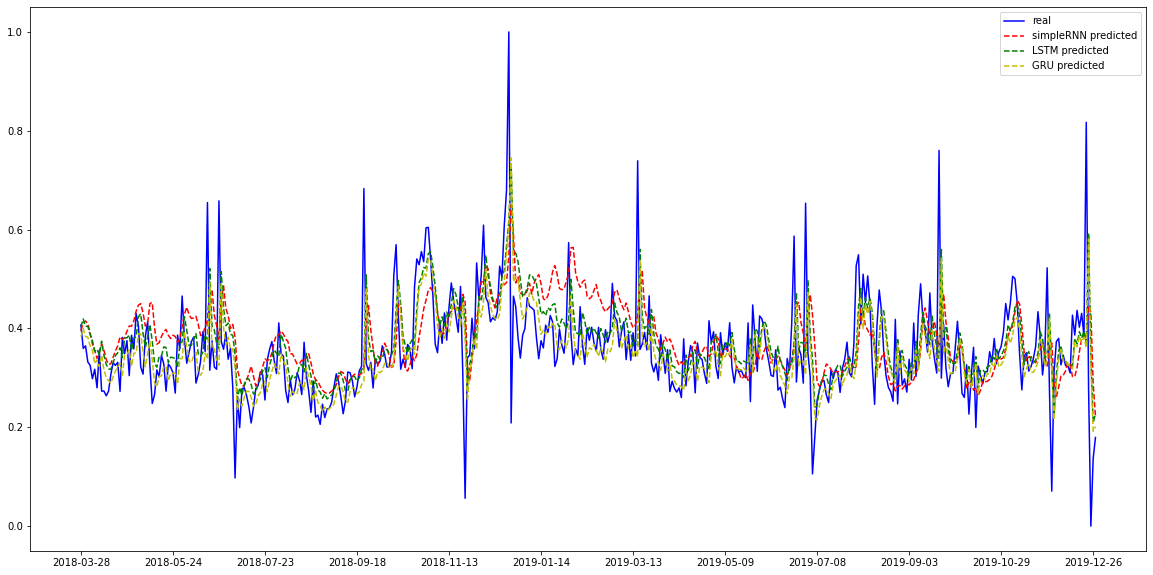

In [50]:
# the prediction of ’Close’ value
plt.figure(figsize=(20,10))
plt.plot(testY_, 'b-', label = 'real')  
plt.plot(predicted_stock_price_simpleRNN, 'r--', label = 'simpleRNN predicted') 
plt.plot(predicted_stock_price_LSTM, 'g--', label = 'LSTM predicted')
plt.plot(predicted_stock_price_GRU, 'y--', label = 'GRU predicted')
plt.legend(loc='upper right')
testX_i = testX.index[Time_steps:-1]
plt.xticks(ticks=range(0, len(testX.index), 40), labels=testX_i[::40])
#plt.xticks(ticks=range(0, len(testX.index), 40), labels=testX.index[::40])
plt.show()

(ix) (10%) Test the model on 2020 data. Does it perform well under COVID-19 conditions? (show results)

In [68]:
df_2020 = read_data('S_P_2020_2.csv', 'Date', '2019-12-01', '2020-11-30')

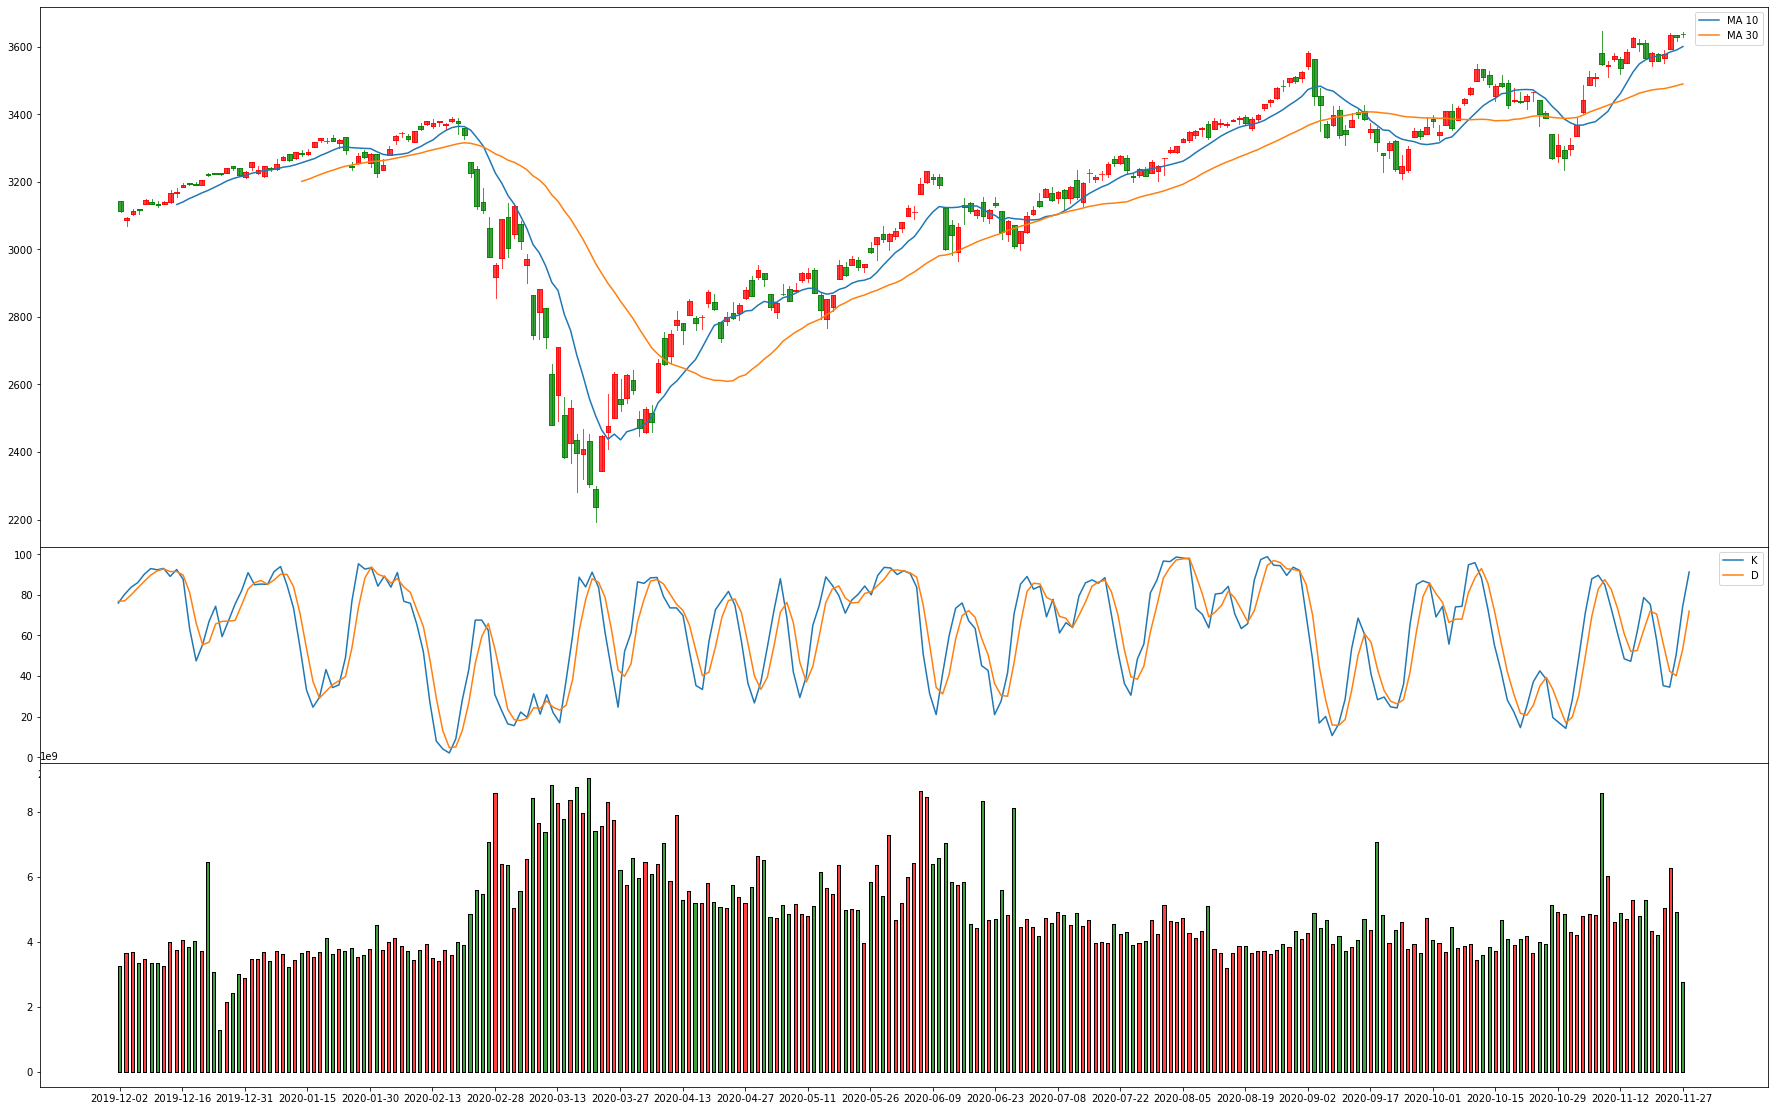

In [69]:
plot_candlestick_kdline_volumebar(df_2020)

In [70]:
##### adding features #####
moving_average(df_2020, 10)
moving_average(df_2020, 30)
kd(df_2020)

##### X, Y #####
testY_2020 = df_2020['Close']
testX_2020 = df_2020.drop(columns=['Close', 'Adj Close'])

##### normalization #####
testX_2020 = normalize(testX_2020)

##### drop the record that has NaN value #####
testX_2020.dropna(inplace=True)

#### dimension transform #####
testX_2020_, testY_2020_ = transform_dimension(testX_2020, testY_2020, Time_steps=30, out_days=1)

trainX shape:  (191, 30, 8) 
trainY shape:  (191, 1)
batch size, time step:  30 , input dimension:  8


In [72]:
simpleRNN_predict_2020 = simpleRNN_model.predict(testX_2020_)
LSTM_predict_2020 = LSTM_model.predict(testX_2020_)
GRU_predict_2020 = GRU_model.predict(testX_2020_)

比較圖，把所有線畫在同一張圖上

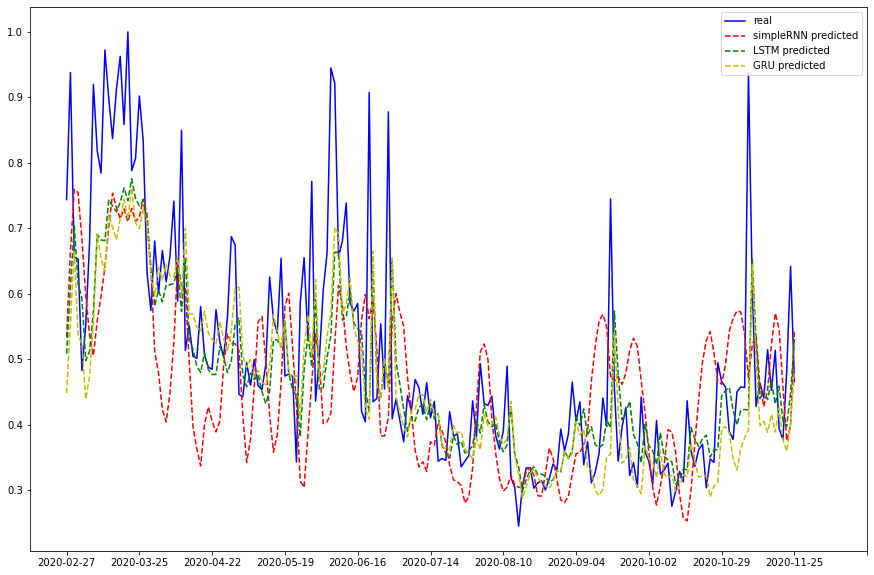

In [77]:
# the prediction of ’Close’ value
plt.figure(figsize=(15,10))
plt.plot(testY_2020_, 'b-', label = 'real')  
plt.plot(simpleRNN_predict_2020, 'r--', label = 'simpleRNN predicted') 
plt.plot(LSTM_predict_2020, 'g--', label = 'LSTM predicted')
plt.plot(GRU_predict_2020, 'y--', label = 'GRU predicted')
plt.legend(loc='upper right')
testX_2020_i = testX_2020.index[Time_steps:-1]
plt.xticks(ticks=range(0, len(testX_2020.index), 19), labels=testX_2020_i[::19])
plt.show()